STEP 0: Install Required Libraries

In [55]:
# This cell installs the required libraries in Colab
!pip install pandas numpy matplotlib scikit-learn ta yfinance prophet openpyxl

STEP 1: Load and Preprocess Historical Stock Data

In [56]:
import pandas as pd

# Load the data from your uploaded Excel file
df = pd.read_excel('/content/yahoo_data.xlsx')

# Display the first 5 rows to understand the structure
print("Sample Data:")
display(df.head())

# Check column names and data types
print("\nColumns and Data Types:")
print(df.dtypes)


Sample Data:


,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000



Columns and Data Types:
Date            object
Open           float64
High           float64
Low            float64
Close*         float64
Adj Close**    float64
Volume           int64
dtype: object


STEP 2: Calculate Financial Indicators (SMA, EMA, RSI, Bollinger Bands)

In [48]:
import ta

# If your dataset has multiple companies, split by 'Ticker' or similar column.
# Let's check if there is a 'Ticker' or 'Symbol' column:
ticker_col = None
for col in df.columns:
    if 'ticker' in col.lower() or 'symbol' in col.lower():
        ticker_col = col
        break

# We'll work with one company first for demonstration
if ticker_col:
    company = df[ticker_col].unique()[0]
    company_df = df[df[ticker_col] == company].copy()
    print(f"Working on company: {company}")
else:
    company_df = df.copy()
    print("No Ticker column found. Proceeding with the available data.")

# Ensure 'Date' is datetime and sort
company_df['Date'] = pd.to_datetime(company_df['Date'])
company_df = company_df.sort_values('Date')

# Calculate indicators using 'ta' library
company_df['SMA_20'] = ta.trend.sma_indicator(company_df['Close*'], window=20)
company_df['EMA_20'] = ta.trend.ema_indicator(company_df['Close*'], window=20)
company_df['RSI_14'] = ta.momentum.rsi(company_df['Close*'], window=14)
boll = ta.volatility.BollingerBands(close=company_df['Close*'], window=20, window_dev=2)
company_df['BB_High'] = boll.bollinger_hband()
company_df['BB_Low'] = boll.bollinger_lband()

display(company_df.tail())


No Ticker column found. Proceeding with the available data.


,Date,Open,High,Low,Close*,Adj Close**,Volume,SMA_20,EMA_20,RSI_14,BB_High,BB_Low
4,2023-04-24,33805.04,33891.15,33726.09,33875.40,33875.40,252020000,33490.7210,33529.486015,61.284626,34479.597783,32501.844217
3,2023-04-25,33828.34,33875.49,33525.39,33530.83,33530.83,297880000,33545.6585,33529.614013,52.384158,34407.042485,32684.274515
2,2023-04-26,33596.34,33645.83,33235.85,33301.87,33301.87,321170000,33591.0395,33507.924107,47.452559,34284.208230,32897.870770
1,2023-04-27,33381.66,33859.75,33374.65,33826.16,33826.16,343240000,33646.4675,33538.232287,57.353340,34218.018770,33074.916230
0,2023-04-28,33797.43,34104.56,33728.40,34098.16,34098.16,354310000,33708.4240,33591.558736,61.415126,34186.032712,33230.815288


STEP 3: Unsupervised Anomaly Detection (Isolation Forest)

In [49]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Use selected columns for anomaly detection (drop NA)
features = company_df[['Close*', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_High', 'BB_Low']].dropna()
X = features.values

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
anomaly_labels = iso_forest.fit_predict(X)

# Add anomaly label to dataframe
features['Anomaly'] = anomaly_labels
features['Date'] = company_df.loc[features.index, 'Date'].values
features['Close*'] = company_df.loc[features.index, 'Close*'].values

# -1 means anomaly, 1 means normal
print(f"Total anomalies detected: {(anomaly_labels == -1).sum()}")
# Print all rows where anomaly detected
anomalies = features[features['Anomaly'] == -1]
print("Anomalies detected (showing all anomaly rows):")
print(anomalies)



Total anomalies detected: 25
Anomalies detected (showing all anomaly rows):
       Close*      SMA_20        EMA_20     RSI_14       BB_High  \
788  21200.62  26705.5210  26033.954651  25.047290  31108.966674   
786  20188.52  25933.1585  25231.811857  29.312732  30938.067020   
785  21237.38  25533.4180  24851.389775  34.328306  30695.131359   
784  19898.92  25060.9625  24379.725987  31.278335  30463.710745   
783  20087.19  24604.3230  23970.913036  32.190958  30067.271593   
782  19173.98  24113.4015  23514.062271  30.102731  29674.557421   
781  18591.93  23644.9580  23045.287769  28.819501  29405.646534   
780  20704.91  23326.1355  22822.394648  38.987535  28995.874995   
779  21200.55  23038.2835  22667.933253  41.112514  28522.865639   
778  22552.17  22877.5600  22656.908181  46.576863  28219.449974   
777  21636.78  22688.9310  22559.753116  43.624422  27925.281795   
776  22327.48  22470.1390  22537.631867  46.385999  27372.276844   
775  21917.16  22270.1265  22478.539308 

STEP 4: Time-Series Forecasting (Prophet)

In [50]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = company_df[['Date', 'Close*']].rename(columns={'Date': 'ds', 'Close*': 'y'})
prophet_df = prophet_df.dropna()

# Fit the model
model = Prophet(daily_seasonality=True)
model.fit(prophet_df)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Merge forecast with real data
result = pd.merge(prophet_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
result['Deviation'] = np.abs(result['y'] - result['yhat'])


DEBUG:cmdstanpy:input tempfile: /tmp/tmpsmjetnfa/nse0df1d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsmjetnfa/c3y3oiw_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83053', 'data', 'file=/tmp/tmpsmjetnfa/nse0df1d.json', 'init=/tmp/tmpsmjetnfa/c3y3oiw_.json', 'output', 'file=/tmp/tmpsmjetnfa/prophet_modelstakb6jm/prophet_model-20250523091151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:11:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:11:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


STEP 5: Visualize Detected Anomalies

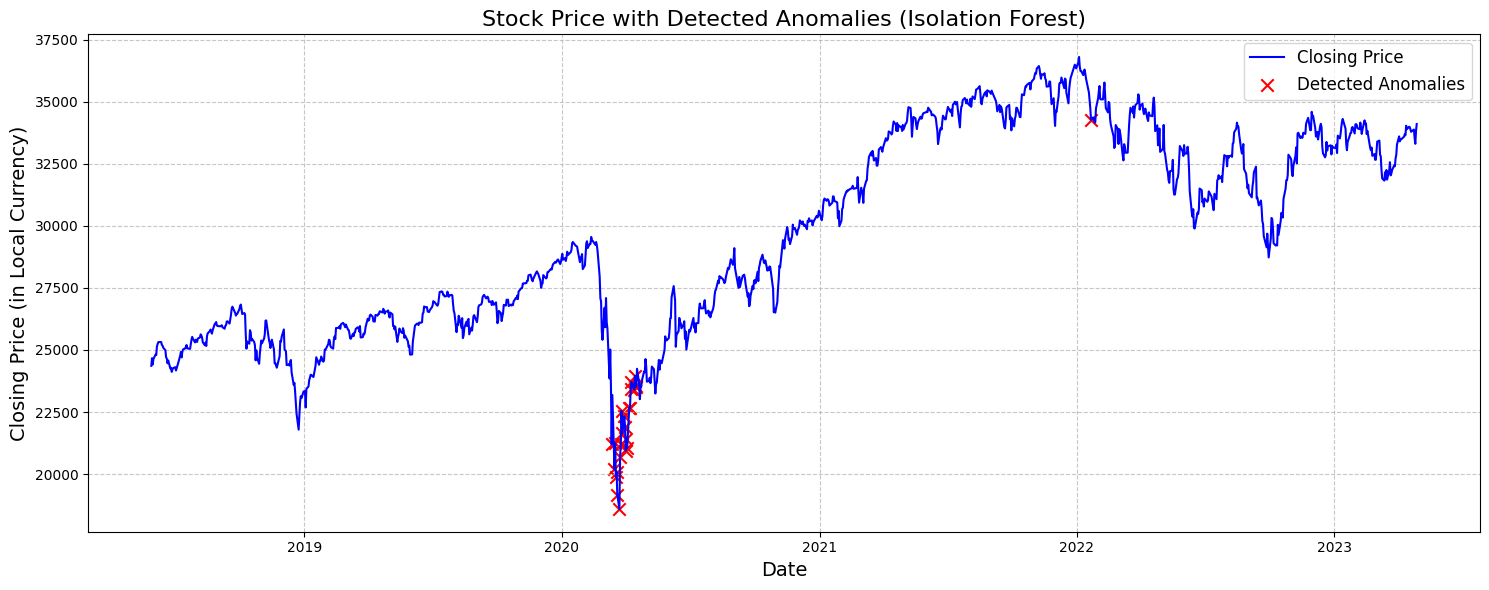

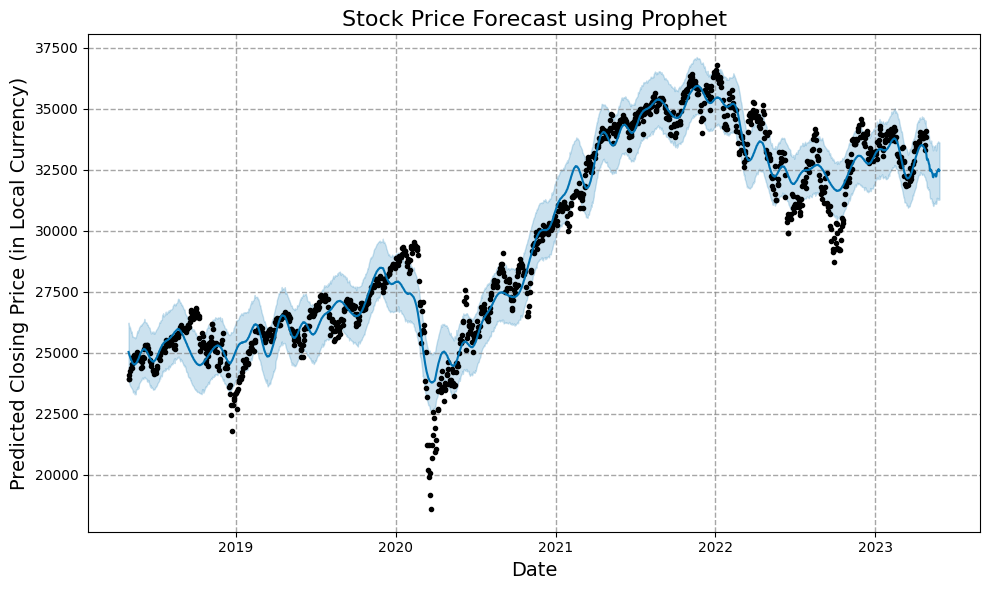

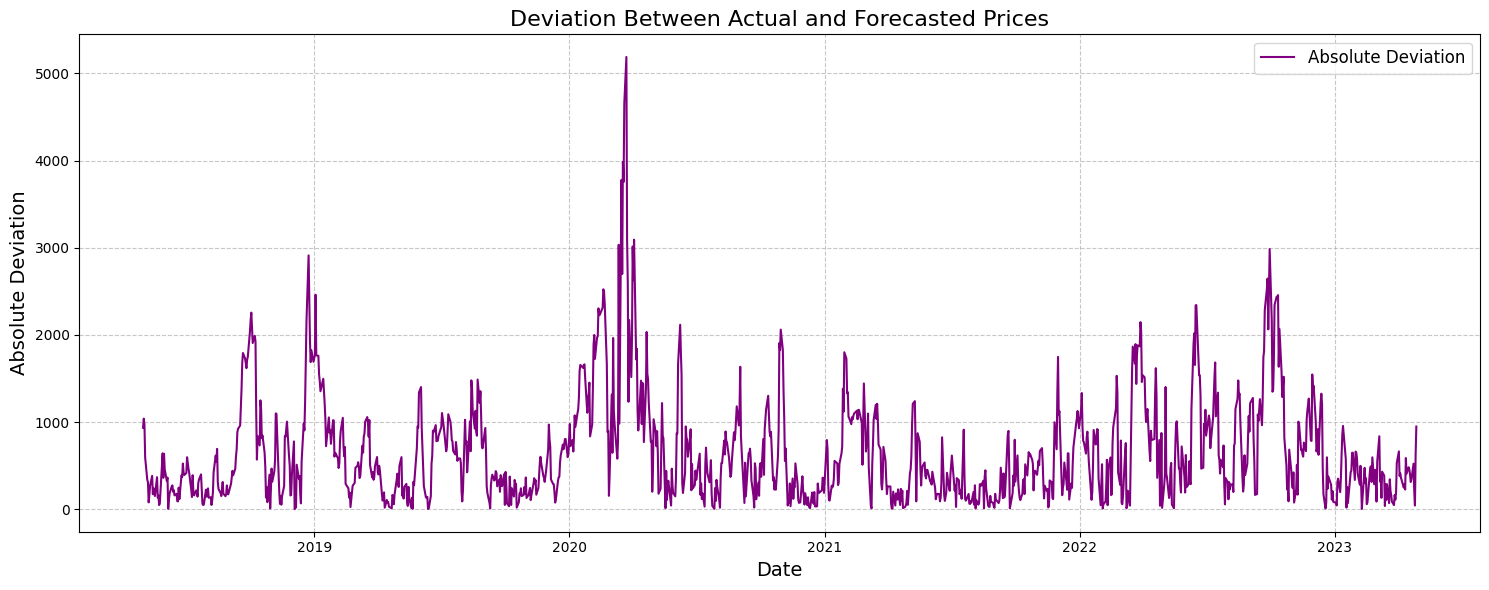

In [51]:
import matplotlib.pyplot as plt

# --- 1. Plot Detected Anomalies in Stock Price ---
plt.figure(figsize=(15, 6))
plt.plot(features['Date'], features['Close*'], label='Closing Price', color='blue')
plt.scatter(features.loc[features['Anomaly'] == -1, 'Date'],
            features.loc[features['Anomaly'] == -1, 'Close*'],
            color='red', label='Detected Anomalies', marker='x', s=80)
plt.title('Stock Price with Detected Anomalies (Isolation Forest)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price (in Local Currency)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 2. Prophet Forecast Plot ---
fig1 = model.plot(forecast)
plt.title('Stock Price Forecast using Prophet', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Predicted Closing Price (in Local Currency)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 3. Plot Deviation from Prophet Forecast ---
plt.figure(figsize=(15, 6))
plt.plot(result['ds'], result['Deviation'], color='purple', label='Absolute Deviation')
plt.title('Deviation Between Actual and Forecasted Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Absolute Deviation', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


STEP 6: Make This a Gradio App for Any File

In [52]:
!pip install gradio

In [53]:
def analyze_stock(file):
    import pandas as pd
    import numpy as np
    import ta
    import matplotlib.pyplot as plt
    from sklearn.ensemble import IsolationForest
    from prophet import Prophet

    df = pd.read_excel(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    if 'Ticker' in df.columns:
        df = df[df['Ticker'] == df['Ticker'].iloc[0]]
    df['SMA_20'] = ta.trend.sma_indicator(df['Close*'], window=20)
    df['EMA_20'] = ta.trend.ema_indicator(df['Close*'], window=20)
    df['RSI_14'] = ta.momentum.rsi(df['Close*'], window=14)
    boll = ta.volatility.BollingerBands(close=df['Close*'], window=20, window_dev=2)
    df['BB_High'] = boll.bollinger_hband()
    df['BB_Low'] = boll.bollinger_lband()
    features = df[['Close*', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_High', 'BB_Low']].dropna()
    X = features.values
    iso_forest = IsolationForest(contamination=0.02, random_state=42)
    anomaly_labels = iso_forest.fit_predict(X)
    features['Anomaly'] = anomaly_labels
    features['Date'] = df.loc[features.index, 'Date'].values
    features['Close*'] = df.loc[features.index, 'Close*'].values
    prophet_df = df[['Date', 'Close*']].rename(columns={'Date': 'ds', 'Close*': 'y'}).dropna()
    model = Prophet(daily_seasonality=True)
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    result = pd.merge(prophet_df, forecast[['ds', 'yhat']], on='ds', how='left')
    result['Deviation'] = np.abs(result['y'] - result['yhat'])
    # Plot 1: Anomaly chart
    fig1, ax1 = plt.subplots(figsize=(12,5))
    ax1.plot(features['Date'], features['Close*'], label='Closing Price', color='blue')
    ax1.scatter(features.loc[features['Anomaly']==-1, 'Date'],
                features.loc[features['Anomaly']==-1, 'Close*'],
                color='red', label='Anomaly', marker='x', s=80)
    ax1.set_title('Stock Price with Detected Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Closing Price')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    fig1.tight_layout()
    # Plot 2: Prophet Forecast
    fig2 = model.plot(forecast)
    ax2 = fig2.gca()
    ax2.set_title('Stock Price Forecast (Prophet)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Predicted Closing Price')
    ax2.grid(True, linestyle='--', alpha=0.5)
    fig2.tight_layout()
    # Plot 3: Deviation Plot
    fig3, ax3 = plt.subplots(figsize=(12,5))
    ax3.plot(result['ds'], result['Deviation'], color='purple', label='Absolute Deviation')
    ax3.set_title('Deviation Between Actual and Forecasted Prices')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Absolute Deviation')
    ax3.legend()
    ax3.grid(True, linestyle='--', alpha=0.5)
    fig3.tight_layout()
    anomalies = features[features['Anomaly']==-1][['Date','Close*']]
    anomalies = anomalies.sort_values('Date').tail(10)
    return (fig1, fig2, fig3, anomalies)


In [54]:
iface = gr.Interface(
    fn=analyze_stock,
    inputs=gr.File(label="Upload Yahoo Finance Excel File"),
    outputs=[
        gr.Plot(label="Detected Anomalies"),
        gr.Plot(label="Prophet Forecast"),
        gr.Plot(label="Deviation Plot"),
        gr.Dataframe(label="Recent Anomalies (Date & Price)")
    ],
    title="Financial Anomaly Detection Tool",
    description="Upload Yahoo Finance data (xlsx). Detects anomalies using Isolation Forest and Prophet. Shows all graphs and anomaly table."
)
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6753058b14fffe8502.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
